In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data

In [ ]:
stock_df = pd.read_csv('/content/drive/MyDrive/work/upload_DJIA_table.csv')
sentiment_df = pd.read_csv('/content/drive/MyDrive/work/news_label_daily_sentiment_scores.csv')

stock_df['Date'] = pd.to_datetime(stock_df['Date'])
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

In [ ]:
stock_df = stock_df.sort_values('Date').reset_index(drop=True)
sentiment_df = sentiment_df.sort_values('Date').reset_index(drop=True)

In [ ]:
sentiment_df.drop(columns=['Label'], inplace=True)
sentiment_df.head()

,Date,sentiment_score
0,2008-08-08,0.68
1,2008-08-11,1.04
2,2008-08-12,0.92
3,2008-08-13,0.64
4,2008-08-14,0.88


In [ ]:
merged_df = pd.merge(stock_df, sentiment_df, left_on='Date', right_on='Date', how='inner')

In [ ]:
merged_df

,Date,Open,High,Low,Close,Volume,Adj Close,sentiment_score
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0.68
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1.04
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.92
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.64
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.88
...,...,...,...,...,...,...,...,...
1984,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.48
1985,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.68
1986,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.72
1987,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,0.68


In [ ]:
merged_df['Next_Close'] = merged_df['Adj Close'].shift(-1)
merged_df['Label'] = (merged_df['Next_Close'] >= merged_df['Adj Close']).astype(int)
# merged_df = merged_df.dropna(subset=['Next_Close'])

In [ ]:
merged_df

,Date,Open,High,Low,Close,Volume,Adj Close,sentiment_score,Next_Close,Label
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0.68,11782.349609,1
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1.04,11642.469727,0
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.92,11532.959961,0
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.64,11615.929688,1
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.88,11659.900391,1
...,...,...,...,...,...,...,...,...,...,...
1984,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.48,17409.720703,1
1985,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.68,17694.679688,1
1986,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.72,17929.990234,1
1987,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234,0.68,17949.369141,1


# LSTM Prediction

In [ ]:
df = merged_df.copy()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,Date,Open,High,Low,Close,Volume,Adj Close,sentiment_score,Next_Close,Label
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0.68,11782.349609,1
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1.04,11642.469727,0
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.92,11532.959961,0
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.64,11615.929688,1
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.88,11659.900391,1
...,...,...,...,...,...,...,...,...,...,...
1983,2016-06-24,17946.630859,17946.630859,17356.339844,17400.750000,239000000,17400.750000,0.68,17140.240234,0
1984,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234,0.48,17409.720703,1
1985,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703,0.68,17694.679688,1
1986,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688,0.72,17929.990234,1


In [ ]:
SEQ_LENGTH = 20
HIDDEN_DIM = 64
NUM_LAYERS = 2
BATCH_SIZE = 15
EPOCHS = 50
LEARNING_RATE = 0.001
TRAIN_SPLIT = 0.8

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Adj Close,sentiment_score,Next_Close,Label
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0.68,11782.349609,1
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,1.04,11642.469727,0
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.92,11532.959961,0
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.64,11615.929688,1
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.88,11659.900391,1


In [ ]:
# feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'sentiment_score']
feature_cols = ['sentiment_score']
target_col = 'Label'

In [ ]:
# scaler = MinMaxScaler()
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
data_x = df[feature_cols].values
data_y = df[target_col].values

In [ ]:
def create_sequences(x, y, seq_len):
    xs, ys = [], []
    for i in range(len(x) - seq_len):
        _x = x[i : i+seq_len]
        _y = y[i+seq_len]
        xs.append(_x)
        ys.append(_y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_x, data_y, SEQ_LENGTH)

In [ ]:
train_size = int(len(X) * TRAIN_SPLIT)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [ ]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## LSTM Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.sigmoid(out)
        return out

In [ ]:
import torch.optim as optim

input_dim = len(feature_cols)
output_dim = 1

model = LSTMClassifier(input_dim, HIDDEN_DIM, NUM_LAYERS, output_dim).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    logging_interval = 10

    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        probas = model(data)

        loss = criterion(probas.squeeze(), target)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted = (probas.squeeze() > 0.5).float()
        total += target.size(0)
        correct += (predicted == target).sum().item()

        # # log metrics
        # if batch_idx % logging_interval == 0:
        #    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #        epoch, batch_idx * len(data), len(train_loader.dataset),
        #        100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = train_loss / len(train_loader)
    train_accuracy = 100.0 * correct / total
    print(f"Train Epoch {epoch}: Average Loss: {avg_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

In [ ]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            probas = model(data)

            loss = criterion(probas.squeeze(), target)
            test_loss += loss.item()

            predicted = (probas.squeeze() > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Epoch {epoch}: Average Loss: {avg_loss:.4f}, Accuracy: {test_accuracy:.2f}%\n')

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

Train Epoch 1: Average Loss: 0.6908, Accuracy: 53.56%
Test Epoch 1: Average Loss: 0.6932, Accuracy: 51.02%

Train Epoch 2: Average Loss: 0.6901, Accuracy: 54.26%
Test Epoch 2: Average Loss: 0.6935, Accuracy: 51.02%

Train Epoch 3: Average Loss: 0.6904, Accuracy: 54.26%
Test Epoch 3: Average Loss: 0.6928, Accuracy: 51.02%

Train Epoch 4: Average Loss: 0.6904, Accuracy: 54.26%
Test Epoch 4: Average Loss: 0.6926, Accuracy: 51.02%

Train Epoch 5: Average Loss: 0.6900, Accuracy: 54.26%
Test Epoch 5: Average Loss: 0.6927, Accuracy: 51.02%

Train Epoch 6: Average Loss: 0.6898, Accuracy: 54.26%
Test Epoch 6: Average Loss: 0.6931, Accuracy: 51.02%

Train Epoch 7: Average Loss: 0.6897, Accuracy: 54.26%
Test Epoch 7: Average Loss: 0.6931, Accuracy: 51.02%

Train Epoch 8: Average Loss: 0.6899, Accuracy: 54.26%
Test Epoch 8: Average Loss: 0.6930, Accuracy: 51.02%

Train Epoch 9: Average Loss: 0.6899, Accuracy: 54.26%
Test Epoch 9: Average Loss: 0.6931, Accuracy: 51.02%

Train Epoch 10: Average Loss

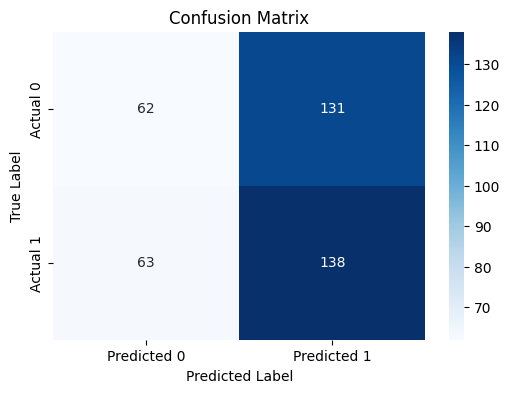

In [ ]:
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

y_pred = np.concatenate(y_pred_list, axis=0)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()